
This notebook presents a simple way to introduce RNN (recurrent neural networks) and LSTM (long short term memory networks) for price movement predictions in trading Forex, Stock Market. Deep Learning has been advertised as the ultimate prediction algorithm, in here we put it to the test in trading and price movement predictions. Technical indicators can be added as well  such as the relative strength indicator RSI and moving averages MA to extend the input data for the trading model.

X is downloaded from yahoo finance. Y (target for prediction) is the next day price. This algo predicts the next day price given 30 days of historical prices(backcandles = 30)


In [54]:
# enter your desired stock ticker, default value is 'MSFT'
ticker = 'MSFT'
# startDate , as per our convenience we can modify
startDate = datetime.datetime(2014, 12, 24)
# endDate , as per our convenience we can modify
endDate = datetime.datetime(2024, 12, 24)

In [55]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import yfinance as yf
import datetime

In [56]:
data = yf.download(tickers = ticker, start = startDate, end = endDate)
data.head(10)

/tmp/ipython-input-56-102215585.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers = ticker, start = startDate, end = endDate)
[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,MSFT,MSFT,MSFT,MSFT,MSFT
Date,,,,,
2014-12-24,41.179157,41.606859,41.127835,41.606859,11437800
2014-12-26,40.956757,41.410120,40.905431,41.410120,13197800
2014-12-29,40.588936,40.871218,40.426407,40.802787,14439500
2014-12-30,40.221100,40.734341,40.067127,40.580368,16384700
2014-12-31,39.733521,40.580369,39.733521,39.973033,21552500
2015-01-02,39.998699,40.563266,39.810512,39.913160,27913900
2015-01-05,39.630882,39.973042,39.562448,39.665096,39673900
2015-01-06,39.049202,39.990145,38.955107,39.673647,36447900


In [57]:
data['TargetNextClose'] = data['Close'].shift(-1)
data.reset_index(inplace = True)
data.drop(['Volume', 'Date'], axis=1, inplace=True)

/tmp/ipython-input-57-2943779794.py:3: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  data.drop(['Volume', 'Date'], axis=1, inplace=True)


In [58]:
## for technical analysis
#!pip install pandas-ta
#import pandas_ta as ta

In [59]:
# # Adding indicators
# data['RSI']=ta.rsi(data.Close, length=15)
# data['EMAF']=ta.ema(data.Close, length=20)
# data['EMAM']=ta.ema(data.Close, length=100)
# data['EMAS']=ta.ema(data.Close, length=150)

# data['Target'] = data['Adj Close']-data.Open
# data['Target'] = data['Target'].shift(-1)

# data['TargetClass'] = [1 if data.Target[i]>0 else 0 for i in range(len(data))]

# data['TargetNextClose'] = data['Adj Close'].shift(-1)

# data.dropna(inplace=True)
# data.reset_index(inplace = True)
# data.drop(['Volume', 'Close', 'Date'], axis=1, inplace=True)

In [60]:
data_set = data.iloc[:, 0:11]#.values
pd.set_option('display.max_columns', None)

data_set.head(10)
#print(data_set.shape)
#print(data.shape)
#print(type(data_set))

Price,Close,High,Low,Open,TargetNextClose
Ticker,MSFT,MSFT,MSFT,MSFT,
0,41.179157,41.606859,41.127835,41.606859,40.956757
1,40.956757,41.410120,40.905431,41.410120,40.588936
2,40.588936,40.871218,40.426407,40.802787,40.221100
3,40.221100,40.734341,40.067127,40.580368,39.733521
4,39.733521,40.580369,39.733521,39.973033,39.998699
5,39.998699,40.563266,39.810512,39.913160,39.630882
6,39.630882,39.973042,39.562448,39.665096,39.049202
7,39.049202,39.990145,38.955107,39.673647,39.545334
8,39.545334,39.742076,38.912337,39.331483,40.708687


In [61]:
#Target column Categories
#y =[1 if data.Open[i]>data.Close[i] else 0 for i in range(0, len(data))]
#yi = [data.Open[i]-data.Close[i] for i in range(0, len(data))]
#print(yi)
#print(len(yi))

In [62]:
# scaling the data
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range=(0,1))
data_set_scaled = sc.fit_transform(data_set)
print(data_set_scaled)

[[0.01541718 0.01514975 0.01574374 0.01606152 0.0148993 ]
 [0.0148993  0.01469188 0.01522229 0.01560263 0.0140428 ]
 [0.0140428  0.01343771 0.01409918 0.01418603 0.01318626]
 ...
 [0.93329447 0.94576579 0.93839069 0.94514406 0.93229703]
 [0.93229703 0.94706407 0.92042982 0.92537055 0.9291655 ]
 [0.9291655  0.93294537 0.9302394  0.93380513        nan]]


In [ ]:
# multiple feature from data provided to the model
X = []
#print(data_set_scaled[0].size)
#data_set_scaled=data_set.values
backcandles = 30
print(data_set_scaled.shape[0])
for j in range(4):#data_set_scaled[0].size):#2 columns are target not X
    X.append([])
    for i in range(backcandles, data_set_scaled.shape[0]):#backcandles+2
        X[j].append(data_set_scaled[i-backcandles:i, j])

#move axis from 0 to position 2
X=np.moveaxis(X, [0], [2])

#Erase first elements of y because of backcandles to match X length
#del(yi[0:backcandles])
#X, yi = np.array(X), np.array(yi)
# Choose -1 for last column, classification else -2...
X, yi =np.array(X), np.array(data_set_scaled[backcandles:,-1])
y=np.reshape(yi,(len(yi),1))
#y=sc.fit_transform(yi)
#X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
print(X)
print(X.shape)
print(y)
print(y.shape)

In [64]:
#also comprehensions for X
#X = np.array([data_set_scaled[i-backcandles:i,:4].copy() for i in range(backcandles,len(data_set_scaled))])
#print(X)
#print(X.shape)

In [65]:
# split data into train test sets
splitlimit = int(len(X)*0.8)
print(splitlimit)
X_train, X_test = X[:splitlimit], X[splitlimit:]
y_train, y_test = y[:splitlimit], y[splitlimit:]
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)
print(y_train)

1988
(1988, 30, 4)
(498, 30, 4)
(1988, 1)
(498, 1)
[[0.00438215]
 [0.00394394]
 [0.00535815]
 ...
 [0.45477664]
 [0.46956548]
 [0.46684963]]


In [66]:
# Build the LSTM model
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Dense
from keras.layers import TimeDistributed

import tensorflow as tf
import keras
from keras import optimizers
from keras.callbacks import History
from keras.models import Model
from keras.layers import Dense, Dropout, LSTM, Input, Activation, concatenate
import numpy as np
#tf.random.set_seed(20)
np.random.seed(10)

lstm_input = Input(shape=(backcandles, 4), name='lstm_input')
inputs = LSTM(150, name='first_layer')(lstm_input)
inputs = Dense(1, name='dense_layer')(inputs)
output = Activation('linear', name='output')(inputs)
model = Model(inputs=lstm_input, outputs=output)
adam = optimizers.Adam()
model.compile(optimizer=adam, loss='mse')
model.fit(x=X_train, y=y_train, batch_size=15, epochs=30, shuffle=True, validation_split = 0.1)

Epoch 1/30
120/120 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 0.0084 - val_loss: 7.2166e-04
Epoch 2/30
120/120 ━━━━━━━━━━━━━━━━━━━━ 6s 37ms/step - loss: 1.1239e-04 - val_loss: 5.8596e-04
Epoch 3/30
120/120 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 1.3946e-04 - val_loss: 6.2921e-04
Epoch 4/30
120/120 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 1.2565e-04 - val_loss: 6.3391e-04
Epoch 5/30
120/120 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - loss: 1.1941e-04 - val_loss: 5.5361e-04
Epoch 6/30
120/120 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 1.2021e-04 - val_loss: 5.4135e-04
Epoch 7/30
120/120 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 1.2153e-04 - val_loss: 5.4427e-04
Epoch 8/30
120/120 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 1.0769e-04 - val_loss: 9.1534e-04
Epoch 9/30
120/120 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - loss: 1.1624e-04 - val_loss: 5.0829e-04
Epoch 10/30
120/120 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 1.2869e-04 - val_loss: 4.9615e-04
Epoch 11/30
120/120 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step

In [67]:
y_pred = model.predict(X_test)
#y_pred=np.where(y_pred > 0.43, 1,0)
for i in range(10):
    print(y_pred[i], y_test[i])

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
[0.4629731] [0.46630185]
[0.46424863] [0.44238422]
[0.46734437] [0.42688798]
[0.45591336] [0.43286736]
[0.4433353] [0.43786536]
[0.4354065] [0.44181365]
[0.4369923] [0.45760665]
[0.43964404] [0.46385987]
[0.44706172] [0.4655031]
[0.45475897] [0.4680592]


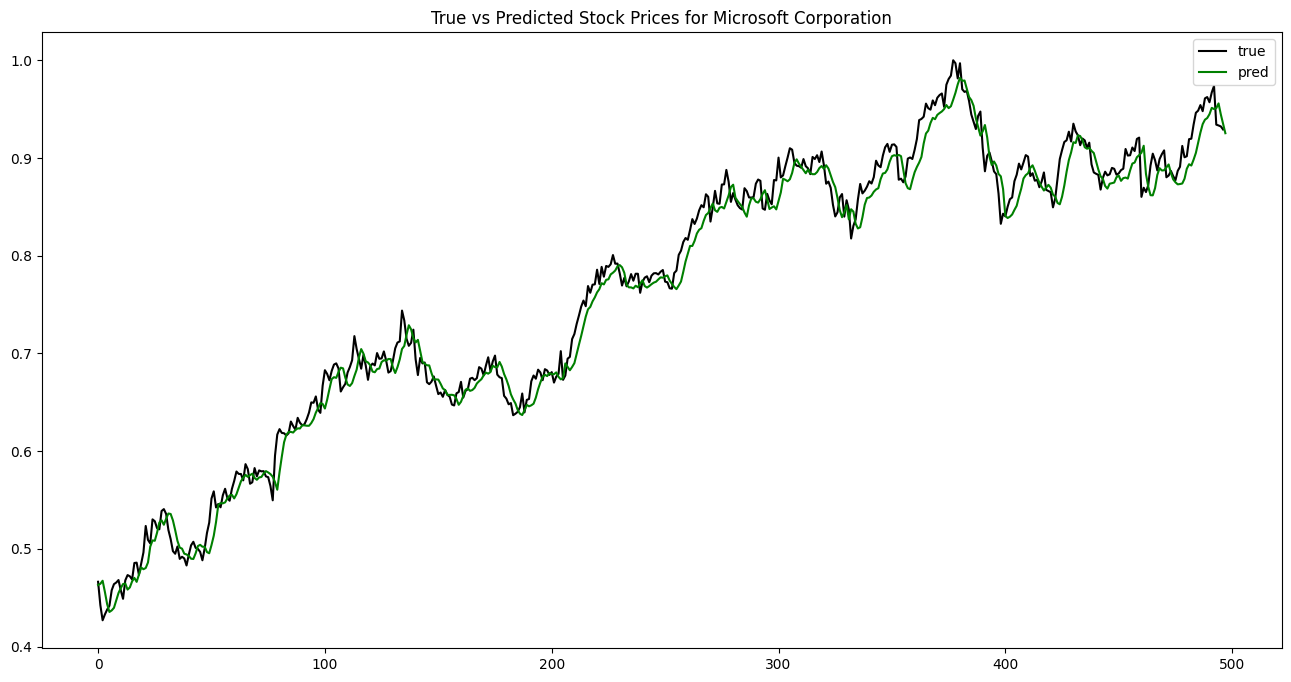

In [69]:
plt.figure(figsize=(16,8))
plt.plot(y_test, color = 'black', label = 'true')
plt.plot(y_pred, color = 'green', label = 'pred')
plt.legend()
# adding ticker name to title
tickerName = yf.Ticker(ticker).info['shortName']
plt.title( 'True vs Predicted Stock Prices for '+ tickerName )
plt.show()


## Source: https://www.youtube.com/@CodeTradingCafe
